<div class='bar_title'></div>

*Introduction to Data Science*

# Spatial Data Analytics

Gunther Gust<br>
Chair for Enterprise AI

Winter Semester 25/26

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/d3.png" style="width:20%; float:left;" />

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/CAIDASlogo.png" style="width:20%; float:left;" />

# Content

* Motivation
* Modeling Spatial Relations
* Measuring Spatial Dependence
* Models for Spatial Data
* Spatial data leakage


# Motivation

Many business problems are **not independent in space**. Customers, stores, suppliers, and risks are **embedded in geographic context**.

### Typical spatial business questions
- 🏪 **Location & Expansion**  
  *Where should we open the next store? Why do nearby stores affect each other?*
- 🚚 **Logistics & Supply Chains**  
  *Why do delivery delays and disruptions cluster regionally?*
- 🧑‍🤝‍🧑 **Customer Analytics**  
  *Do churn, demand, or customer value show regional patterns?*
- 🌍 **Risk & ESG**  
  *Where do environmental, regulatory, or climate risks concentrate?*
- 📈 **Pricing & Valuation**  
  *Why do similar assets (e.g. real estate) have different values depending on location?*


> **If nearby units influence each other, space must be part of the analysis.**

Ignoring spatial structure leads to:
- biased models   
- poor strategic decisions  

➡️ **Spatial Data Analytics makes “where” a first-class variable in business decision-making.**

## Analogy: Temporal vs. Spatial Dependence

### Temporal dependence (last lecture)
> **Observations close in time are more similar than distant ones.**

Examples:
- Sales today depend on sales yesterday  
- Demand shows trends, seasonality, and persistence  
- Ignoring time dependence leads to poor forecasts

➡️ **Time = ordering + dependence**

## Spatial dependence (this lecture)
> **Tobler’s First Law of Geography:**  
> *“Everything is related to everything else, but near things are more related than distant things.”*

Examples:
- Nearby regions have similar income levels  
- Store performance depends on neighboring stores  
- Environmental and market risks cluster geographically

➡️ **Space = location + neighborhood effects**

> **Time and space play the same structural role:**  
> they introduce dependence between observations and violate independence assumptions.  


➡️ **Spatial data therefore requires special models and methods.**

# Modeling Space


## 2.1 Motivation: How can we represent space in data?

Unlike time, space has **no natural ordering**.  
To model spatial dependence, we must **explicitly define relationships**.

### Key idea
> **Space is represented through neighborhoods.**

### How this works
- We define **who is a neighbor of whom** (e.g. sharing a border, being close in distance)
- Each observation is linked to a **local neighborhood**
- Taken together, these local definitions induce a **global spatial structure**

➡️ **By defining neighbors locally, we model spatial dependence globally.**

### Consequence
> The definition of neighborhoods is a **modeling decision**, not a technical detail.

## 2.2 Defining Neighborhood Relationships

To model spatial dependence, we must define **who is a neighbor of whom**.

There is no single “correct” definition of neighborhood.  
Different definitions capture **different mechanisms of interaction**.

### Three common approaches
- **Contiguity-based neighbors** (shared borders)
- **Distance-based neighbors**
- **k-nearest neighbors**

➡️ The choice depends on the **data** and the **business question**.

## Contiguity-Based Neighbors (Shared Borders)

### Idea
Two regions are neighbors if they **share a boundary**.

### Variants
- **Rook contiguity**: shared edge only  
- **Queen contiguity**: shared edge or corner  


<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/queen_rook_adjacency.png" style="width:50%; float:center;" />


### Typical use cases
- Administrative regions (districts, municipalities)
- Socio-economic regional data

➡️ Neighborhood structure follows **geography, not distance**.

In [7]:
%matplotlib inline

import seaborn as sns
import pandas as pd
from pysal.lib import weights
from libpysal.io import open as psopen
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

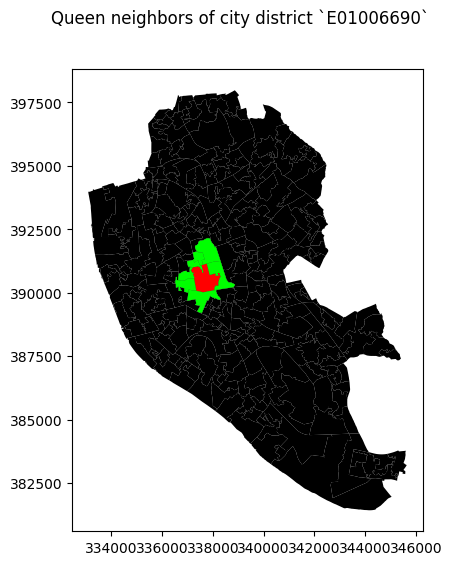

In [8]:
# Read the file in
db = gpd.read_file("https://raw.githubusercontent.com/GuntherGust/sc_gdsa_data/main/liv_lsoas.gpkg")
db = db.set_index("LSOA11CD", drop=False)

w_queen = weights.Queen.from_dataframe(db, ids="LSOA11CD")

# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
db.plot(ax=ax, facecolor='k', linewidth=0.1)
focus = db.loc[['E01006690'], ['geometry']]
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
neis = db.loc[w_queen.neighbors['E01006690'], :] # Plot neighbors
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Title
f.suptitle("Queen neighbors of city district `E01006690`")
plt.show()

## Distance-Based Neighbors

### Idea
Two observations are neighbors if the **distance between them** is below a given threshold.

Examples:
- all locations within 100 km
- all stores within 15 minutes travel time

### Typical use cases
- Retail competition
- Accessibility
- Environmental exposure

➡️ Captures **distance decay** explicitly.

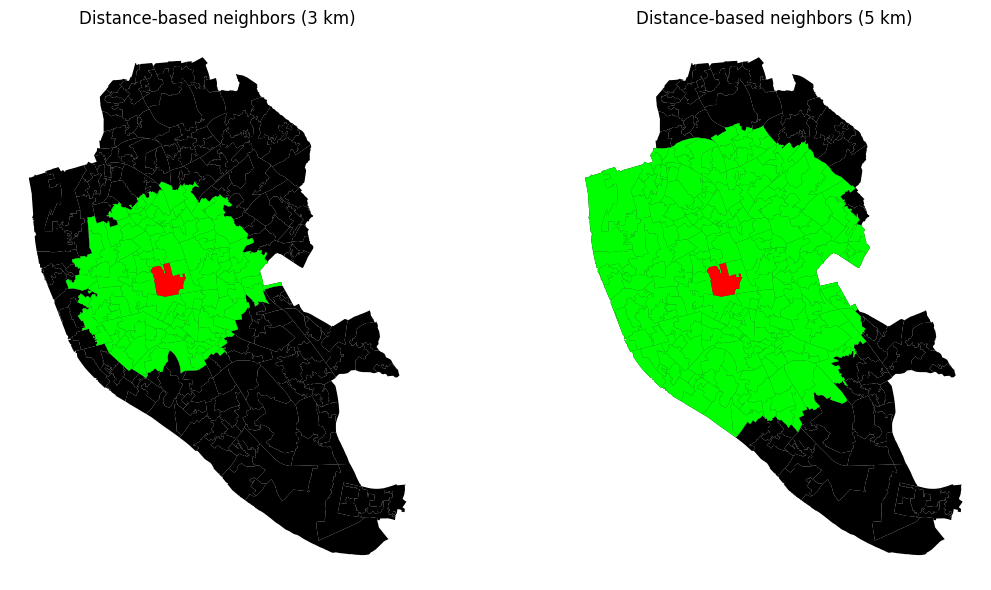

In [9]:
# Distance-based neighbors: 3 km and 5 km
w_dist3km = weights.DistanceBand.from_dataframe(db, 3000)
w_dist5km = weights.DistanceBand.from_dataframe(db, 5000)

# Focus region
focus_id = 'E01006690'
focus = db.loc[[focus_id], ['geometry']]

# Neighbors
neis_3km = db.loc[w_dist3km.neighbors[focus_id], :]
neis_5km = db.loc[w_dist5km.neighbors[focus_id], :]

# Setup figure (side by side)
f, ax = plt.subplots(1, 2, figsize=(12, 6))

# --- 3 km ---
db.plot(ax=ax[0], facecolor='k', linewidth=0.1)
neis_3km.plot(ax=ax[0], facecolor='lime', linewidth=0)
focus.plot(ax=ax[0], facecolor='red', linewidth=0)
ax[0].set_title("Distance-based neighbors (3 km)")
ax[0].axis("off")

# --- 5 km ---
db.plot(ax=ax[1], facecolor='k', linewidth=0.1)
neis_5km.plot(ax=ax[1], facecolor='lime', linewidth=0)
focus.plot(ax=ax[1], facecolor='red', linewidth=0)
ax[1].set_title("Distance-based neighbors (5 km)")
ax[1].axis("off")

plt.tight_layout()
plt.show()


### Inverse distance-based weights

Every observation $i$ is assigned a weight equal to the inverse distance between it and its neighbor $j$:

$$
w_{ij} = \dfrac{1}{d_{ij}}
$$

This way, the further apart $i$ and $j$ are from each other, the smaller the weight $w_{ij}$ will be.

/home/vscode/.local/lib/python3.11/site-packages/scipy/sparse/_data.py:132: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


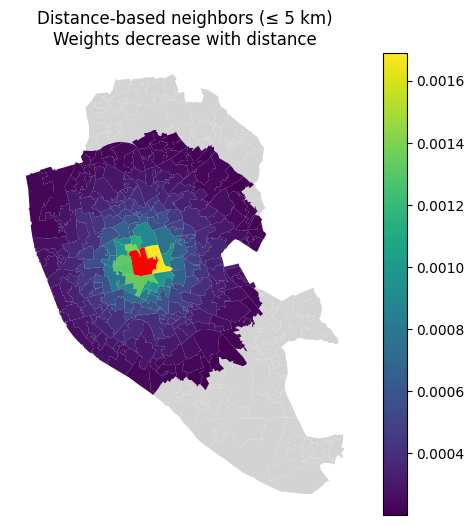

In [10]:
# Distance-based neighbors with weights (1 / distance)
w_dist1kmC = weights.DistanceBand.from_dataframe(
    db,
    threshold=5000,
    binary=False # binary=False means spatial influence decays with distance
                # (neighbors are not just in/out, but weighted)
)

# Focus region
focus_id = 'E01006690'
focus = db.loc[[focus_id], ['geometry']]

# Neighbor indices
neis_idx = w_dist1kmC.neighbors[focus_id]

# Neighbor GeoDataFrame
neis = db.loc[neis_idx, :].copy()

# Extract weights for coloring
neis["weight"] = [
    w_dist1kmC.weights[focus_id][i]
    for i in range(len(neis_idx))
]

# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))

# Base layer
db.plot(ax=ax, facecolor='lightgrey', linewidth=0.1)

# Neighbors colored by weight
neis.plot(
    ax=ax,
    column="weight",
    cmap="viridis",
    legend=True,
    linewidth=0
)

# Focus region
focus.plot(ax=ax, facecolor='red', linewidth=0)

# Title
ax.set_title("Distance-based neighbors (≤ 5 km)\nWeights decrease with distance")
ax.axis("off")

plt.show()


### Backround: Treating all observations as neighbors?

* Not computationally practical as distance matrices would become __very large__

* In practical terms, what is usually done is to impose a distance threshold beyond which no weight is assigned and interaction is assumed to be non-existent. 

* A commonly used threshold, although not always best, is that which makes every observation to have at least __one neighbor.__ 


## k-Nearest Neighbors (k-NN)

### Idea
Each observation is connected to its **k closest neighbors**.

### Typical use cases
- Uneven spatial distributions
- Point data (stores, events)
- When every observation must have neighbors

➡️ Guarantees **connectivity**, even in sparse regions.

## 2.3 From Space to Weight Matrices

Once neighborhood relationships are defined, spatial relationships are
**formalized as weight matrices**.

### Core idea
- Each observation is related to **other observations via weights**
- Space is no longer a map, but a **matrix representation**


### Spatial weight matrix $W$

- Entry $w_{ij}$: strength of spatial influence from observation $j$ on $i$
- Typical properties:
  - $w_{ij} > 0$ if $j$ is a neighbor of $i$
  - $w_{ij} = 0$ otherwise
- Often row-standardized:
  - $\sum_j w_{ij} = 1$
  
  ### Key insight
> **The spatial model lives in the weight matrix $W$.**

➡️ $W$ encodes *who influences whom*  
➡️ All spatial statistics and models (Moran’s $I$, spatial lags, spatial regression) are built on $W$

# 3. Measuring Spatial Dependence

### Independence (benchmark case)
Two observations are **independent** if knowing one gives **no information** about the other.

Formally:
- $\mathbb{E}[y_i \mid y_j] = \mathbb{E}[y_i]$
- This is the standard assumption in many statistical models



### Dependence
Observations are **dependent** if:
> knowing the value at one location changes our expectation about another.

Examples:
- **Time series**: today’s sales depend on yesterday’s sales  
- **Spatial data**: a region’s value depends on neighboring regions

## 3.1 Global Spatial Autocorrelation

It answers the question:
> *“Are similar values spatially clustered across the study area?”*


### Moran’s $I$
Moran’s $I$ measures **overall spatial clustering** in the data.

$$
I \;=\;
\overbrace{
\frac{n}{\sum_i \sum_j w_{ij}}
}^{\text{Scaling for sample size and total spatial connectivity}}
\;\cdot\;
\frac{
\overbrace{
\sum_i \sum_j w_{ij}\,(y_i - \bar{y})(y_j - \bar{y})
}^{\text{Similarity between neighboring observations}}
}{
\underbrace{
\sum_i (y_i - \bar{y})^2
}_{\text{Overall variance of the data}}
}
$$

### Where
- $n$ : number of observations  
- $y_i$ : value at location $i$  
- $\bar{y}$ : mean of the variable  
- $w_{ij}$ : element of the spatial weight matrix $W$  
- $\sum_i \sum_j w_{ij}$ : sum of all spatial weights  

➡️ Moran’s $I$ is a **spatially weighted correlation** between observations and their neighbors.


### Interpretation

- Moran’s $I$ is approximately bounded by $[-1, 1]$
- $I > 0$ : positive spatial autocorrelation (similar values cluster in space) 
- $I < 0$ : negative spatial autocorrelation (neighboring values are dissimilar)  
- $I \approx 0$ : spatial randomness  

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/spatial_autocorrelation.png" style="width:80%; float:center;" />


## Moran’s $I$ vs. Pearson Correlation $\rho_{xy}$: Same Math, Different Assumptions

### Pearson correlation
Measures association between **two variables** $x$ and $y$:

$$
\rho_{xy}
\;=\;
\frac{
\sum_i (x_i - \bar{x})(y_i - \bar{y})
}{
\sqrt{\sum_i (x_i - \bar{x})^2}
\;\sqrt{\sum_i (y_i - \bar{y})^2}
}
$$

### Mathematical similarity
Both Pearson correlation and Moran’s $I$ are based on the same idea:

> **Normalized cross-products of deviations from the mean**

- Pearson correlation:
  - compares $(x_i - \bar{x})$ with $(y_i - \bar{y})$
- Moran’s $I$:
  - compares $(y_i - \bar{y})$ with $(y_j - \bar{y})$
  - weighted by spatial proximity $w_{ij}$

➡️ **Formally, both are correlation-type statistics.**




### Crucial difference: assumptions

| Pearson correlation | Moran’s $I$ |
|--------------------|-------------|
| Dependence between **variables** | Dependence between **observations** |
| Observations assumed **independent** | Observations explicitly **dependent** |
| No spatial structure | Spatial structure encoded in $W$ |
| Valid under i.i.d. | Signals violation of i.i.d. |


## Example: Spatial Autocorrelation in Britain's Brexit Referendum

We will use the results of the 2016 referendum vote to leave the EU, at the local authority level. In particular, we will focus on the __spatial distribution of the vote to Leave__, which ended up winning. 

From a technical point of view, you will be working with polygons which have a value (the percentage of the electorate that voted to Leave the EU) attached to them.

In [11]:
import esda
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation
)

# Read the file in
br = gpd.read_file(
    "https://raw.githubusercontent.com/GuntherGust/sc_gdsa_data/main/brexit.gpkg"
)
br = br.set_index("lad16cd", drop=False)

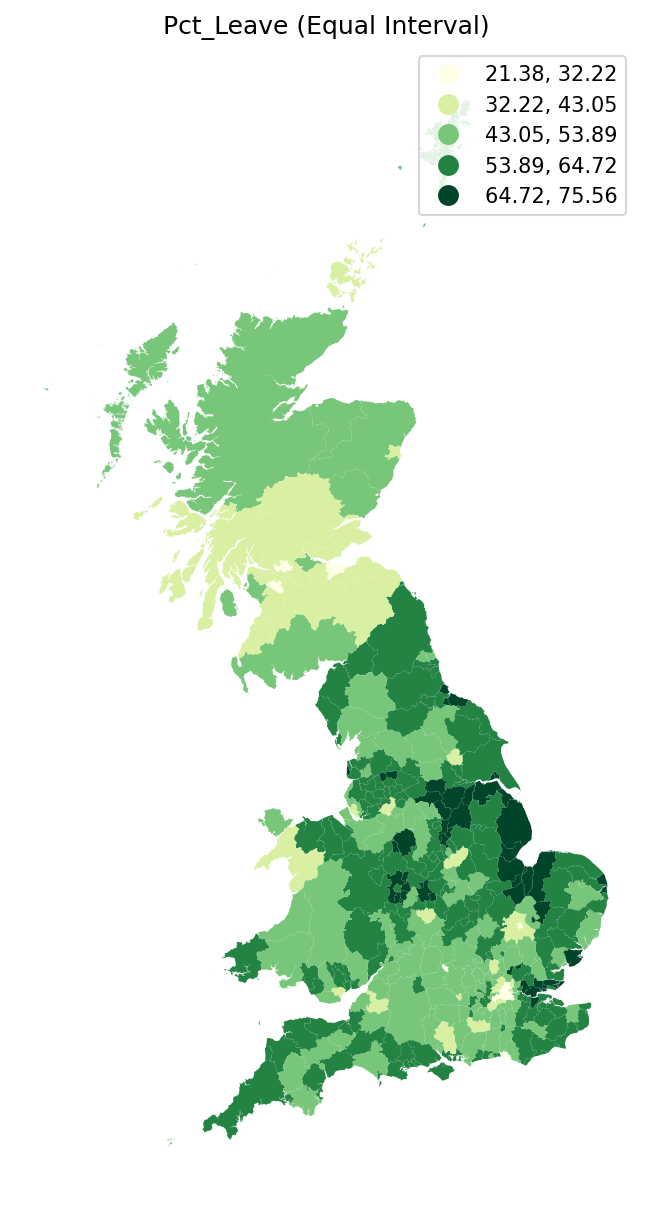

In [12]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)

br.plot(
    ax=ax,
    column="Pct_Leave",
    scheme="equal_interval",
    cmap="YlGn",
    legend=True
)

ax.set_title("Pct_Leave (Equal Interval)")
ax.axis("off")
plt.show()

## Exercise

> Is the Brexit vote of the regions spatially correlated? If so, how much?

Answer on [Mentimeter](https://www.menti.com/albvnvdbg13f).

In [13]:
# Create the spatial weights matrix, remove disconnected components
w_temp = weights.Queen.from_dataframe(br, ids="lad16cd")
br = br.drop(w_temp.islands)

#Recalculate weight matrix
w = weights.Queen.from_dataframe(br, ids="lad16cd")
w.transform = 'R' # Row standardize the matrix

mi = esda.Moran(br['Pct_Leave'], w)
mi.I

/home/vscode/.local/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: E06000046, E06000053, S12000013, S12000023, S12000027, W06000001.
  W.__init__(self, neighbors, ids=ids, **kw)


0.6228641407137806

## Decomposing Global Moran’s $I$

Global Moran’s $I$ is an **average of local relationships**.

Each observation contributes:
- its own value
- and the average value of its neighbors

➡️ Instead of collapsing everything into one number, we can visualize these relationships using the __Moran Scatterplot.__



## Moran Scatterplot

For each observation $i$, we plot:

- x-axis: standardized value $z_i$

- y-axis: spatial lag (neighbors’ average)$ \sum_j w_{ij} z_j $
 


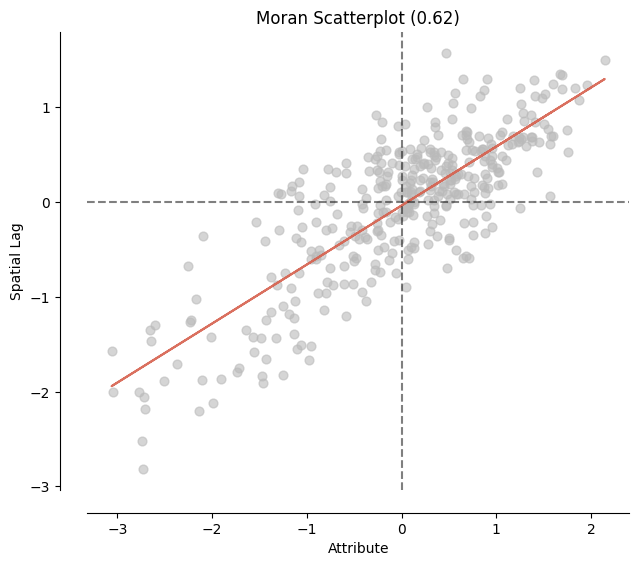

In [14]:
moran_scatterplot(mi);

- Each point visualizes a **local relationship**
- The fitted regression line summarizes all points

➡️ **The slope of this line equals Global Moran’s $I$.**

## Quadrants = Local Spatial Patterns

The four quadrants of the scatterplot correspond to:

- **High–High (HH)**: cluster of high values  
- **Low–Low (LL)**: cluster of low values  
- **High–Low (HL)**: spatial outlier  
- **Low–High (LH)**: spatial outlier

## 3.2 Local Spatial Autocorrelation (LISA)

The Moran scatterplot shows **where local patterns exist**. LISA tells us **which of these patterns are statistically significant**.

LISA = *Local Indicators of Spatial Association*

## Local Moran’s $I$: Core Idea

For each location $i$, Local Moran’s $I_i$ is defined as:

$$
I_i = z_i \sum_j w_{ij} z_j
$$

where:
- $z_i = \frac{y_i - \bar{y}}{s}$ is the standardized value


### Interpretation
- $I_i > 0$ → location is similar to its neighbors (local cluster)
- $I_i < 0$ → location differs from its neighbors (local outlier)



Local Moran’s $I_i$ is **not interpreted directly**. Instead, its significance is assessed using a **permutation test**. 

➡️ LISA maps show **statistically significant local spatial patterns only**:

<Figure size 2250x2250 with 0 Axes>

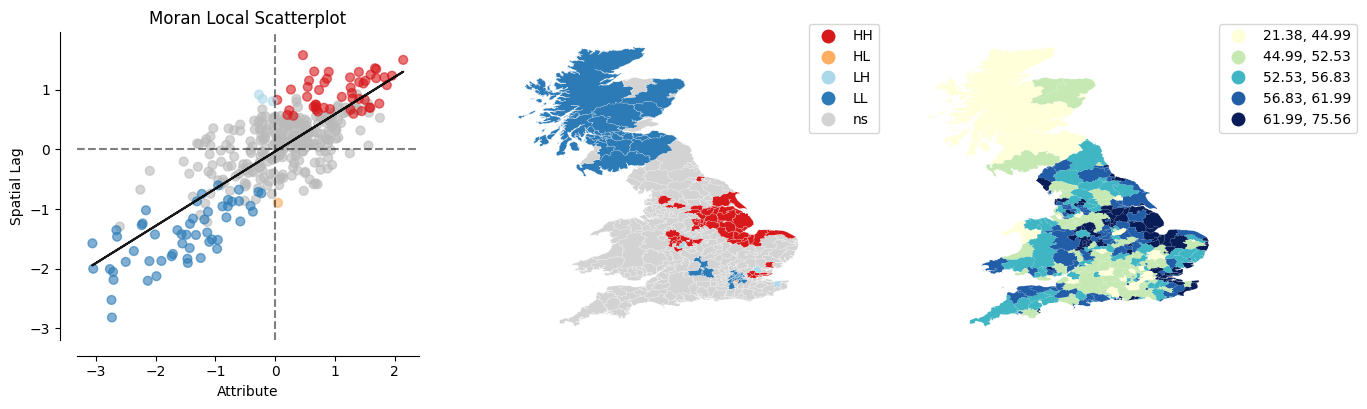

In [15]:
import matplotlib.pyplot as plt

lisa = esda.Moran_Local(br['Pct_Leave'], w)

plt.figure(figsize=(15, 15), dpi=150)
plot_local_autocorrelation(lisa, br, 'Pct_Leave')
plt.show();


### Typical business use case of LISA:

- 🏪 **Retail**:  
  - HH → strong regional markets  
  - HL → best-practice stores in weak regions  
  - LH → management or execution problems  

- 🚚 **Logistics & Operations**:  
  - regional bottlenecks and spillovers  

- ⚠️ **Risk & Compliance**:  
  - localized risk hot spots  

### Key insight
> **Business decisions are local — LISA makes spatial diagnostics actionable.**

➡️ LISA turns spatial patterns into **targeted, place-specific decisions**.

# 4. Integrating Space into Statistical Models 

Once spatial dependence is detected, there are **two main modeling strategies**:


**A) Feature engineering + Conventional Models**  
→ space as explanatory information  

**B) Spatial dependence models**  
→ space as interaction and spillovers

## 4.1 Feature Engineering + Conventional Models

**Idea:**  
Encode spatial information as features and use standard models. 

__Examples:__
- $x, y$ (lon/lat or projected)
- $x^2, y^2, xy$ (captures smooth, non-linear spatial patterns)
- distance to city center
- neighborhood averages
- spatial lags as additional variables
- cluster or region indicators

__Models__:
- linear regression
- decision trees
- random forests
- gradient boosting
- etc.


### Pros

- ✅ Works with familiar ML models
- ✅ Scales well to large datasets
- ✅ Very flexible (handles nonlinearity & heterogeneity)
- ✅ Often **best predictive performance**
- ✅ Easy integration into ML pipelines

### Cons
- ❌ Spatial effects are implicit
- ❌ Harder to interpret spatial mechanisms
- ❌ Risk of spatial leakage if features are poorly constructed
- ❌ No explicit parameters for spillovers

## 4.2 Spatial Dependence Models

## When Do We Need Spatial Dependence Models?

Spatial dependence models are appropriate if:
- Moran’s $I$ (or residual Moran’s $I$) is significant
- spatial heterogeneity has already been addressed (e.g. through feature engineering)
- spillovers or diffusion processes are plausible

Examples:
- housing prices
- regional growth
- demand spillovers

## The Role of the Spatial Weight Matrix $W$

All spatial dependence models rely on:
- a predefined spatial weight matrix $W$
- encoding *who influences whom* and *how strongly*

➡️ $W$ represents the assumed interaction structure.

## 4.2.1 Spatial Lag Model (SAR)

### Idea
Outcomes depend directly on neighboring outcomes.

Model:
$$
y = \rho W y + X\beta + \varepsilon
$$

Interpretation:
- $\rho$ captures outcome spillovers
- a shock in one region propagates to others

➡️ *“What happens next door affects outcomes here.”*

## 4.2.2 Spatial Error Model (SEM)

### Idea
Spatial dependence arises from **unobserved, spatially correlated factors**.

Model:
$$
y = X\beta + u
$$

$$
u = \lambda W u + \varepsilon
$$

Interpretation:
- missing variables are spatially clustered
- errors are not independent

➡️ *“We forgot something spatial.”*


## 4.2.3  Spatial Lag of X Model (SLX)

### Idea
Covariates in neighboring regions affect the outcome.

Model:
$$
y = X\beta + W X\theta + \varepsilon
$$

Interpretation:
- neighbors’ characteristics matter
- no feedback through $y$

➡️ Spillovers come from **inputs**, not outcomes.


## 4.3 Summary --- Spatial Models: Explanatory vs. Predictive Use

Spatial dependence models (SAR, SEM, SLX) are mainly used to:

- understand **spatial interaction mechanisms**
- quantify **spillovers and feedback effects**
- test hypotheses about **how regions influence each other**

➡️ Their primary role is **explanatory modeling**.


### Why Spatial Models Are Rarely Used for Pure Prediction

- strong assumptions about the weight matrix $W$
- focus on interpretability, not flexibility
- limited scalability to high-dimensional settings

For prediction tasks, practitioners often prefer:
- feature engineering with spatial variables
- flexible machine learning models

> Use __spatial dependence models__ when you want to __explain interactions.__  
> Use feature-based or ML models when you want to __predict__ well.**

Spatial models can predict — but prediction is usually *not* their comparative advantage.

# 5 Spatial Data Leakage

Spatial data introduces a subtle but serious risk for __predictive modeling__:
> **Information can leak across space.**

This can make predictive models look **much better than they really are**.

## What Is Spatial Data Leakage?

Spatial data leakage occurs when:
- training and test observations are **spatially close**
- information flows implicitly across space
- the test set is *not truly independent*

➡️ The model sees “almost the same” locations during training and testing.

➡️ This leads to __inflated performance metrics__ and/or the model fails when deployed to **new or distant locations**

## Analogy: Time vs. Space

You already know this from time series:

- random splits break temporal order
- future information leaks into the past

Spatial data behaves the same way:
- nearby regions share information
- random splits break spatial independence

➡️ **Space breaks i.i.d. just like time does.**

## How to Avoid Spatial Leakage

Rule of thumb:
> Training and test data should be **spatially separated**.

To ensure honest evaluation:

- **Blocked or region-based splits**: Put an entire subregion of your data into the test set:


<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/spatial_blocks.png" style="width:40%; float:center;" />


## Final Note

> **A good spatial validation strategy mimics the deployment scenario.**

Ask:
- Will the model be used in a *new region* (e.g. in a new city)?
- Will the model have access to nearby units, that it can learn from, e.g. predicting a *new locations* in an known region? In this case, spatial data leakage is ok. 

➡️ Validation must reflect **how and where the model will be used**.

# Summary: Spatial Data Analytics — Big Picture

- **Motivation**: Space matters because nearby observations tend to be related.

- **Modeling Spatial Relations**: Space is encoded using neighbors and weight matrices.

- **Measuring Spatial Dependence**: Diagnosing spatial structure with Moran’s $I$ and LISA.

- **Models for Spatial Data**: 
    - Feature Engineering and conventional models
    - Spatial models to measure spatial dependence

- **Spatial Data Leakage**: Spatial dependence breaks the i.i.d. assumption — just like time dependence. Needs proper evaluation strategy, e.g. block-based data splits.



# Mentimeter

Let's resume to our [Mentimeter quiz](https://www.menti.com/albvnvdbg13f). 


<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/d3.png" style="width:50%; float:center;" />